In [249]:
import osmnx as ox
import networkx as nx
import pandas as pd
pd.set_option('display.max_columns', None)
from shapely.geometry import Point

import json
import geopandas as gpd
import matplotlib.pyplot as plt
import GOSTnets as gn
import numpy as np

In [250]:
limaMapa = gpd.read_file("../Turismo/shapes/peru.shp")

<AxesSubplot:>

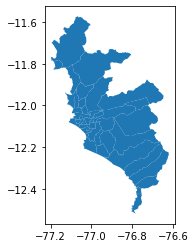

In [251]:
cond = limaMapa['provincia'] == 'LIMA'
limaMapa[cond].plot()

In [252]:
lima_distritos = np.sort(limaMapa[cond]['distrito'].unique())
lima_distritos

array(['ANCON', 'ATE', 'BARRANCO', 'BREÑA', 'CARABAYLLO', 'CHACLACAYO',
       'CHORRILLOS', 'CIENEGUILLA', 'COMAS', 'EL AGUSTINO',
       'INDEPENDENCIA', 'JESUS MARIA', 'LA MOLINA', 'LA VICTORIA', 'LIMA',
       'LINCE', 'LOS OLIVOS', 'LURIGANCHO', 'LURIN', 'MAGDALENA DEL MAR',
       'MIRAFLORES', 'PACHACAMAC', 'PUCUSANA', 'PUEBLO LIBRE',
       'PUENTE PIEDRA', 'PUNTA HERMOSA', 'PUNTA NEGRA', 'RIMAC',
       'SAN BARTOLO', 'SAN BORJA', 'SAN ISIDRO', 'SAN JUAN DE LURIGANCHO',
       'SAN JUAN DE MIRAFLORES', 'SAN LUIS', 'SAN MARTIN DE PORRES',
       'SAN MIGUEL', 'SANTA ANITA', 'SANTA MARIA DEL MAR', 'SANTA ROSA',
       'SANTIAGO DE SURCO', 'SURQUILLO', 'VILLA EL SALVADOR',
       'VILLA MARIA DEL TRIUNFO'], dtype=object)

In [253]:
import time
start = time.time()
print(start)

1629037421.4691584


In [254]:
#Global vars
place_name = "pucusana, Lima"
result = 1

In [255]:
%%time
#Getting graph from OSM
graph = ox.graph_from_place(place_name, which_result=result, network_type='drive')
nodes, edges = ox.graph_to_gdfs(graph)
print(nx.info(graph))

Name: 
Type: MultiDiGraph
Number of nodes: 457
Number of edges: 1146
Average in degree:   2.5077
Average out degree:   2.5077
CPU times: user 3.88 s, sys: 62.4 ms, total: 3.94 s
Wall time: 8.82 s


In [256]:
nodes.head()

,y,x,street_count,highway,geometry
osmid,,,,,
318813749,-12.491887,-76.792846,3,NaN,POINT (-76.79285 -12.49189)
318813750,-12.484027,-76.796057,3,NaN,POINT (-76.79606 -12.48403)
318813751,-12.482597,-76.796612,4,NaN,POINT (-76.79661 -12.48260)
318813753,-12.480314,-76.789954,3,NaN,POINT (-76.78995 -12.48031)
1273453996,-12.485082,-76.797332,1,NaN,POINT (-76.79733 -12.48508)


In [257]:
%%time
#Getting amenities from OSM
amenities = ox.geometries_from_place(place_name, which_result=result ,tags={'amenity':True} )
amenities['isPoint'] = amenities.apply(lambda x: type(x.geometry) is Point , axis=1)
amenities.rename(columns={'geometry':'geometry_polygon'}, inplace=True)
amenities['geometry'] = amenities.apply(lambda x: x['geometry_polygon'].centroid, axis=1)
amenities.set_geometry('geometry')
amenities.set_index('osmid', inplace=True)
# amenities.head()

CPU times: user 1.22 s, sys: 17 ms, total: 1.24 s
Wall time: 3.09 s


In [258]:
_amenity = 'bank'
amenities_as_points = amenities[amenities['amenity'] == _amenity] 
columns = ['unique_id', 'element_type', 'geometry_polygon', 
               'amenity', 'name', 'geometry']

amenities_as_points[columns].head()

,unique_id,element_type,geometry_polygon,amenity,name,geometry
osmid,,,,,,


<AxesSubplot:>

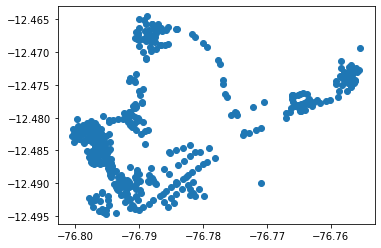

In [259]:
fig, ax = plt.subplots()
nodes.plot(ax=ax)

In [260]:
%%time
def process_amenities(_amenity):

    amenities_as_points = amenities[amenities['amenity'] == _amenity] 
    print("amenities_as_points --> {}".format(amenities_as_points.shape) )
    
    if amenities_as_points.shape[0] == 0:
        return pd.DataFrame()

    ##adding shortest amenity point for all graph nodes
    nodes_amenity = gn.pandana_snap_points( nodes , amenities_as_points ) 

    amenityid = "{}_amenity".format(_amenity)
    amenitydist = "{}_amenity_dist".format(_amenity)
    print(amenityid, amenitydist)

    nodes_amenity.rename(columns={'NN':amenityid, 'NN_dist': amenitydist}, inplace=True)

#     nodes_amenity.head()
    print("nodes_amenity --> {}".format(nodes_amenity.shape))

    ##nearest node for all amenity points
    amenities_as_points2 = gn.pandana_snap(graph, amenities_as_points) 
    print("amenities_as_points2 --> {}".format(amenities_as_points2.shape))

    ######
    columns = ['unique_id', 'element_type', 'geometry_polygon', 
               'amenity', 'name', 'geometry', 'NN', 'NN_dist']

    nodes_amenity2 = nodes_amenity.reset_index().merge(amenities_as_points2[columns], 
                                         how='left', 
                                         left_on=amenityid, 
                                         right_index=True)
    node = "{}_node".format(_amenity)
    nodedist = "{}_node_dist".format(_amenity)
    nodes_amenity2.rename(columns={'NN':node, 'NN_dist': nodedist}, inplace=True)
    print("nodes_amenity2 --> {}".format(nodes_amenity2.shape))
    
    # nodes_amenity2.head()
    #####
    def shortest_path (G, source, target, weight='length'):
        distance = np.NaN
        try:
            distance = nx.shortest_path_length(G, source, target, weight)
        except Exception as e:
            distance = np.NaN
        return distance

    nodedist = "{}_dist".format(_amenity)
    print("Calculating shortest path distance:")
    nodes_amenity2[nodedist] = nodes_amenity2.apply(lambda x:
                                                        shortest_path(graph, x['osmid'], x[node], weight='length'),
                                                        axis=1
                                                       )
    #####
    cols = ['osmid', 'geometry_x', amenityid, node, nodedist ]
#     nodes_amenity2[cols].head()
    return nodes_amenity2

CPU times: user 35 µs, sys: 11 µs, total: 46 µs
Wall time: 49.8 µs


In [261]:
# %%time
# df = process_amenities('hospital')
# df.head()

In [262]:
%%time
import ray
import time

ray.shutdown()
ray.init()
@ray.remote
def f(i):
    time.sleep(1)
    return process_amenities(i)

amenities_filter = ['bank','courthouse','hospital','marketplace', 'police','school','university']

futures = [f.remote(i) for i in amenities_filter]
# print(ray.get(futures))
# ray.get(futures[0])
futures

/home/leibnitz.rojas/.local/lib/python3.6/site-packages/ray/node.py:890: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2021-08-15_09-23-55_217733_1414/logs/redis-shard_0.err' mode='a' encoding='utf-8'>
  self.start_redis()
/home/leibnitz.rojas/.local/lib/python3.6/site-packages/ray/node.py:890: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2021-08-15_09-23-55_217733_1414/logs/redis-shard_0.out' mode='a' encoding='utf-8'>
  self.start_redis()
/home/leibnitz.rojas/.local/lib/python3.6/site-packages/ray/node.py:890: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2021-08-15_09-23-55_217733_1414/logs/redis.err' mode='a' encoding='utf-8'>
  self.start_redis()
/home/leibnitz.rojas/.local/lib/python3.6/site-packages/ray/node.py:890: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2021-08-15_09-23-55_217733_1414/logs/redis.out' mode='a' encoding='utf-8'>
  self.start_redis()
/home/leibnitz.r

CPU times: user 125 ms, sys: 182 ms, total: 307 ms
Wall time: 4.85 s


[ObjectRef(2b1d1545893d1daeffffffffffffffffffffffff0100000001000000),
 ObjectRef(ef25d802e8c24317ffffffffffffffffffffffff0100000001000000),
 ObjectRef(b9c64831282591f9ffffffffffffffffffffffff0100000001000000),
 ObjectRef(faf123d8b1b35293ffffffffffffffffffffffff0100000001000000),
 ObjectRef(02bed209b72c305affffffffffffffffffffffff0100000001000000),
 ObjectRef(e07eebba574c5c52ffffffffffffffffffffffff0100000001000000),
 ObjectRef(7fabc23126d27f51ffffffffffffffffffffffff0100000001000000)]

In [263]:
print("asdasd")

asdasd


In [264]:
%%time
bank = ray.get(futures[0])
courthouse = ray.get(futures[1])
hospital = ray.get(futures[2])
marketplace = ray.get(futures[3])
police = ray.get(futures[4])
school = ray.get(futures[5])
university = ray.get(futures[6])

(pid=4509) amenities_as_points --> (1, 46)
(pid=4561) amenities_as_points --> (0, 46)
(pid=4551) amenities_as_points --> (0, 46)


(pid=4509) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=4509)   return _prepare_from_string(" ".join(pjargs))
(pid=4509) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=4509)   projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
(pid=4509) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecat

(pid=4544) amenities_as_points --> (0, 46)
(pid=4525) amenities_as_points --> (15, 46)
(pid=4518) amenities_as_points --> (2, 46)


(pid=4525) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=4525)   return _prepare_from_string(" ".join(pjargs))
(pid=4525) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=4525)   projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
(pid=4518) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecat

(pid=4516) amenities_as_points --> (0, 46)
(pid=4509) police_amenity police_amenity_dist
(pid=4509) nodes_amenity --> (457, 5)


(pid=4509) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=4509)   return _prepare_from_string(" ".join(pjargs))
(pid=4509) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=4509)   projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
(pid=4509) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecat

(pid=4518) marketplace_amenity marketplace_amenity_dist
(pid=4518) nodes_amenity --> (457, 5)


(pid=4518) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=4518)   return _prepare_from_string(" ".join(pjargs))
(pid=4518) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=4518)   projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
(pid=4518) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecat

(pid=4525) school_amenity school_amenity_dist
(pid=4525) nodes_amenity --> (457, 5)


(pid=4525) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=4525)   return _prepare_from_string(" ".join(pjargs))
(pid=4525) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=4525)   projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
(pid=4525) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecat

(pid=4509) amenities_as_points2 --> (1, 48)
(pid=4509) nodes_amenity2 --> (457, 14)
(pid=4509) Calculating shortest path distance:
(pid=4518) amenities_as_points2 --> (2, 48)
(pid=4518) nodes_amenity2 --> (457, 14)
(pid=4518) Calculating shortest path distance:
(pid=4525) amenities_as_points2 --> (15, 48)
(pid=4525) nodes_amenity2 --> (457, 14)
(pid=4525) Calculating shortest path distance:
CPU times: user 2.58 s, sys: 495 ms, total: 3.08 s
Wall time: 1min 39s


In [265]:
%%time
amenities_filter = ['bank','courthouse','hospital','marketplace', 'police','school','university']

dfcols = []
for a in amenities_filter:
    cols = ['osmid', '{}_amenity'.format(a), '{}_node'.format(a), '{}_dist'.format(a)]
    dfcols.append(cols)
#     print(cols)

dfcols

CPU times: user 32 µs, sys: 0 ns, total: 32 µs
Wall time: 35.3 µs


[['osmid', 'bank_amenity', 'bank_node', 'bank_dist'],
 ['osmid', 'courthouse_amenity', 'courthouse_node', 'courthouse_dist'],
 ['osmid', 'hospital_amenity', 'hospital_node', 'hospital_dist'],
 ['osmid', 'marketplace_amenity', 'marketplace_node', 'marketplace_dist'],
 ['osmid', 'police_amenity', 'police_node', 'police_dist'],
 ['osmid', 'school_amenity', 'school_node', 'school_dist'],
 ['osmid', 'university_amenity', 'university_node', 'university_dist']]

In [266]:
# nodes.head()
pd.DataFrame([], columns = dfcols[0])
courthouse.shape[0] == 0

True

In [267]:
%%time
if bank.shape[0] == 0:
    bank = pd.DataFrame([], columns = dfcols[0])
if courthouse.shape[0] == 0:
    courthouse = pd.DataFrame([], columns = dfcols[1])
if hospital.shape[0] == 0:
    hospital = pd.DataFrame([], columns = dfcols[2])
if marketplace.shape[0] == 0:
    marketplace = pd.DataFrame([], columns = dfcols[3])
if police.shape[0] == 0:
    police = pd.DataFrame([], columns = dfcols[4])
if school.shape[0] == 0:
    school = pd.DataFrame([], columns = dfcols[5])
if university.shape[0] == 0:
    university = pd.DataFrame([], columns = dfcols[6])
    
tmp = nodes.reset_index()
tmp = tmp.merge( bank [dfcols[0]], how='left', on='osmid' )
tmp = tmp.merge( courthouse[dfcols[1]], how='left', on='osmid')
tmp = tmp.merge( hospital[dfcols[2]], how='left', on='osmid' )
tmp = tmp.merge( marketplace[dfcols[3]], how='left', on='osmid' )
tmp = tmp.merge( police[dfcols[4]], how='left', on='osmid' )
tmp = tmp.merge( school[dfcols[5]], how='left', on='osmid' )
tmp = tmp.merge( university[dfcols[6]], how='left', on='osmid' )
tmp.head()

CPU times: user 262 ms, sys: 176 µs, total: 262 ms
Wall time: 257 ms


,osmid,y,x,street_count,highway,geometry,bank_amenity,bank_node,bank_dist,courthouse_amenity,courthouse_node,courthouse_dist,hospital_amenity,hospital_node,hospital_dist,marketplace_amenity,marketplace_node,marketplace_dist,police_amenity,police_node,police_dist,school_amenity,school_node,school_dist,university_amenity,university_node,university_dist
0,318813749,-12.491887,-76.792846,3,NaN,POINT (-76.79285 -12.49189),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173795107,1845510012,1203.366,319479359,318813751,1117.595,4834719123,1845624391,467.693,NaN,NaN,NaN
1,318813750,-12.484027,-76.796057,3,NaN,POINT (-76.79606 -12.48403),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173795107,1845510012,258.201,319479359,318813751,170.096,4235507693,1845510169,38.332,NaN,NaN,NaN
2,318813751,-12.482597,-76.796612,4,NaN,POINT (-76.79661 -12.48260),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173795107,1845510012,192.115,319479359,318813751,0.000,5593354455,1845510005,26.971,NaN,NaN,NaN
3,318813753,-12.480314,-76.789954,3,NaN,POINT (-76.78995 -12.48031),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173795107,1845510012,1424.088,319479359,318813751,1336.279,5774101155,1845508764,625.151,NaN,NaN,NaN
4,1273453996,-12.485082,-76.797332,1,NaN,POINT (-76.79733 -12.48508),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173795107,1845510012,421.206,319479359,318813751,515.069,5593354460,1845510248,249.297,NaN,NaN,NaN


In [268]:
name = place_name.split(',')[0].replace(' ','_')
filename = "simbig21data/{}.csv".format(name)
tmp.to_csv( filename, index=False)

In [269]:
df = pd.read_csv(filename)
df.head()

,osmid,y,x,street_count,highway,geometry,bank_amenity,bank_node,bank_dist,courthouse_amenity,courthouse_node,courthouse_dist,hospital_amenity,hospital_node,hospital_dist,marketplace_amenity,marketplace_node,marketplace_dist,police_amenity,police_node,police_dist,school_amenity,school_node,school_dist,university_amenity,university_node,university_dist
0,318813749,-12.491887,-76.792846,3,NaN,POINT (-76.7928465 -12.4918872),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173795107,1845510012,1203.366,319479359,318813751,1117.595,4834719123,1845624391,467.693,NaN,NaN,NaN
1,318813750,-12.484027,-76.796057,3,NaN,POINT (-76.7960571 -12.4840274),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173795107,1845510012,258.201,319479359,318813751,170.096,4235507693,1845510169,38.332,NaN,NaN,NaN
2,318813751,-12.482597,-76.796612,4,NaN,POINT (-76.79661230000001 -12.4825971),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173795107,1845510012,192.115,319479359,318813751,0.000,5593354455,1845510005,26.971,NaN,NaN,NaN
3,318813753,-12.480314,-76.789954,3,NaN,POINT (-76.78995399999999 -12.4803142),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173795107,1845510012,1424.088,319479359,318813751,1336.279,5774101155,1845508764,625.151,NaN,NaN,NaN
4,1273453996,-12.485082,-76.797332,1,NaN,POINT (-76.79733160000001 -12.4850817),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173795107,1845510012,421.206,319479359,318813751,515.069,5593354460,1845510248,249.297,NaN,NaN,NaN


In [270]:
end = time.time()
print("Processing time : {} secods".format(end-start))

Processing time : 117.43882703781128 secods
